### Convert time to distance travelled by profiler

Develop a function to convert measurements of time from conduino  to distance travelled through the water column
by the probe. 

* It takes 10 s for the probe to complete a cycle

In [1]:
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import pandas as pd
#import seaborn as sns
import scipy.io as sio
from scipy.interpolate import interp1d
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [3]:
def densP(read):
    ''' Calibration from 02 May 2019 in ANK_P20_probes_02may19.ipynb'''
    fitP = 0.998176+(0.001940*read)+(0.001296*read**2)-(0.000073*read**3)

    return(fitP)

def dens_ANK1(read):
    '''Calibration from 02 May 2019 in ANK_P20_probes_02may19.ipynb'''
    rho_1 = 0.998102+0.004567*read+0.000676*read**2+0.000056*read**3 

    return(rho_1)

def dens_ANK2(read):
    '''Calibration from 02 May 2019 in ANK_P20_probes_02may19.ipynb '''
    rho_2 = 0.997984+0.004090*read+0.001643*read**2+0.000193*read**3 

    return(rho_2)

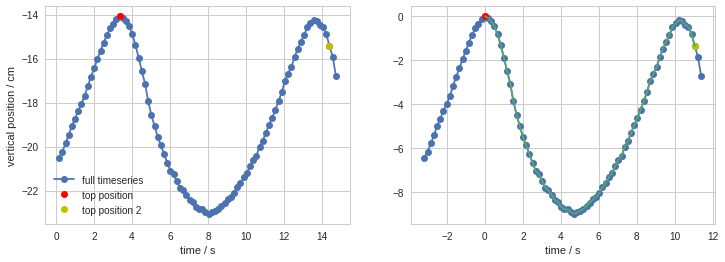

In [4]:
# Find interp function velocity of the profiler
df = pd.read_csv('../profiler_tracking_11jun19.txt', delim_whitespace=True, header=1)

time_p = np.array(df['t'][:])
ydist = np.array(df['y'][:])
top_pos = ydist[19]
top_pos2 = ydist[85]
ini_time = time_p[19]
end_time = time_p[85]

time = time_p[19:86]-ini_time
position = ydist[19:86]-top_pos

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))
ax0.plot(time_p, ydist,'-o', label='full timeseries')
ax0.plot(ini_time, top_pos,'or', label='top position')
ax0.plot(end_time, top_pos2,'oy', label='top position 2')

ax1.plot(time_p-ini_time, ydist-top_pos,'-o', label='cropped timeseries')
ax1.plot(ini_time-ini_time, top_pos-top_pos,'or', label='top position')
ax1.plot(end_time-ini_time, top_pos2-top_pos,'oy', label='top position 2')
ax1.plot(time, position)
ax0.set_xlabel('time / s')
ax1.set_xlabel('time / s')
ax0.set_ylabel('vertical position / cm')
ax0.legend()

Text(0,0.5,'position / cm')

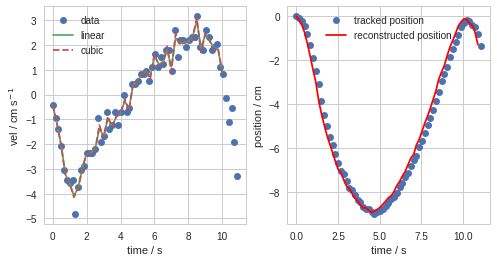

In [5]:
# Find interp function velocity of the profiler

time_small = time[0:-1]
vel = (position[1:]-position[:-1])/(time[1:]-time[:-1])

f = interp1d(time_small, vel)
f2 = interp1d(time_small, vel, kind='cubic')

xnew = np.linspace(0, 10, num=41, endpoint=True)
dist = np.zeros(np.shape(time_small))

for ii in range(1,len(vel)):
    dist[ii] = (vel[ii]*(time_small[ii]-time_small[ii-1]))+dist[ii-1] 

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(time_small, vel, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
ax[1].plot(time, position,'o', label='tracked position')
ax[1].plot(time_small, dist, 'r', label='reconstructed position')

ax[0].legend(['data', 'linear', 'cubic'], loc='best')
ax[1].legend( loc='best')
ax[0].set_xlabel('time / s')
ax[1].set_xlabel('time / s')
ax[0].set_ylabel('vel / cm s$^{-1}$')
ax[1].set_ylabel('position / cm')

No handles with labels found to put in legend.


Text(0.5,0,'time / s')

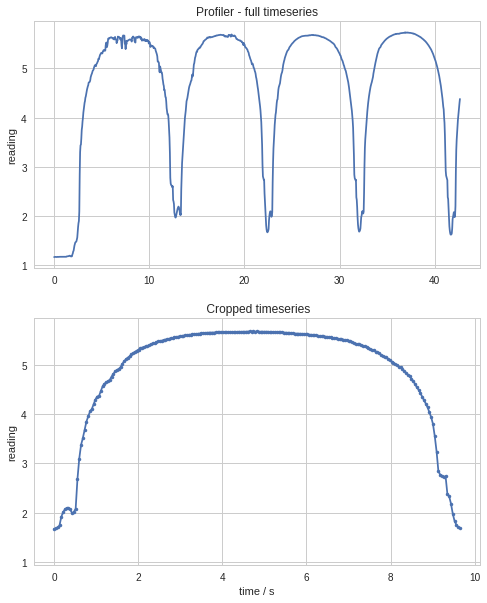

In [6]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(8,10), sharey=True)

filepaths = ['../../Conduino/experiments/exp_04jul19/profile01.mat'   
            ]
ini_indices = [525]
end_indices = [752]

for filepath, ind, end in zip(filepaths, ini_indices, end_indices):
    mat = sio.loadmat(filepath, squeeze_me=True)
    P3 = mat['ch3']#dens_C(mat['ch2'])
    time = mat['time']
    ax0.plot(time[:],P3[:])
    ax1.plot(time[ind:end]-time[ind],P3[ind:end],'.-')
   
ax1.legend(bbox_to_anchor=(1,1))

ax0.set_ylabel('reading')
ax1.set_ylabel('reading')

ax0.set_title('Profiler - full timeseries')
ax1.set_title(' Cropped timeseries')
ax1.set_xlabel('time / s')

Text(1.025,1,'upcast')

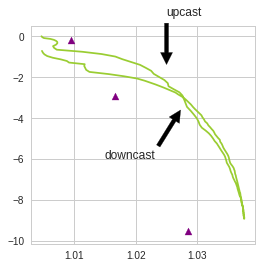

In [7]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

filepath = '../../Conduino/experiments/exp_04jul19/profile01.mat'    
ini = 525
end = 752

mat = sio.loadmat(filepath, squeeze_me=True)
P3 = mat['ch3'] #dens_C(mat['ch2'])
time_cond = mat['time']
   
time_int = time_cond[ind:end]-time_cond[ind]
vel_int = f(time_int)
dist_int = np.zeros(np.shape(time_int))

for ii in range(1,len(time_int)):
    dist_int[ii] = (vel_int[ii]*(time_int[ii]-time_int[ii-1]))+dist_int[ii-1] 


ax.plot(densP(P3[ind:end]),dist_int, label='profiler', color='yellowgreen')
ax.scatter(1.01664,-2.9, marker='^', color='purple')
ax.scatter(1.02852,-9.5, marker='^', color='purple')
ax.scatter(1.00956,-0.2, marker='^', color='purple')

ax.annotate('downcast', xy=(1.0275, -3.5), xytext=(1.015, -6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('upcast', xy=(1.025, -1.5), xytext=(1.025, 1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )


In [8]:
import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
   

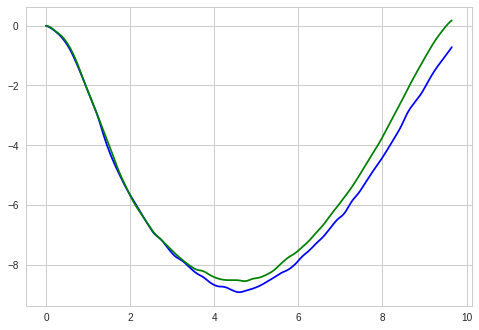

In [9]:
distance = ptools.profiler_11jun(time_int)
distance2 = ptools.profiler_19may(time_int)
plt.plot(time_int,distance, 'b-',time_int,distance2, 'g-')

Text(1.025,1,'upcast')

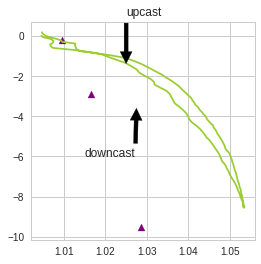

In [11]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

filepath = '../../Conduino/experiments/exp_04jul19/profile01.mat'   
ini = 525
end = 752

mat = sio.loadmat(filepath, squeeze_me=True)
P3 = mat['ch3'] #dens_C(mat['ch2'])
time_cond = mat['time']
   
time_int = time_cond[ind:end]-time_cond[ind]
dist_int = ptools.profiler_19may(time_int)

ax.plot(ptools.densP_06Jul19(P3[ind:end]),dist_int, label='profiler', color='yellowgreen')
ax.scatter(1.016639,-2.9, marker='^', color='purple')
ax.scatter(1.0285,-9.5, marker='^', color='purple')
ax.scatter(1.00956,-0.2, marker='^', color='purple')

ax.annotate('downcast', xy=(1.0275, -3.5), xytext=(1.015, -6),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('upcast', xy=(1.025, -1.5), xytext=(1.025, 1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
